In [1]:
import pandas as pd
from jax import numpy as jnp
import matplotlib.pyplot as plt

from summer2 import CompartmentalModel, Stratification, Multiply
from summer2.parameters import Parameter, DerivedOutput, Function

In [2]:
def get_q_from_matrix(matrix):
    """
    Implementation of equation 8.40 on page 243.
    """
    return (jnp.diag(matrix).sum() - 1.) / (matrix.shape[0] - 1.)

In [3]:
def build_matrix(high_prop, high_partner_change, low_partner_change, ghh):
    """
    Implementation of equation 8.47 on page 246.
    At the end, we need to transpose this matrix,
    with the rationale as described below.
    """
    low_prop = 1. - high_prop
    glh = 1. - ghh
    ghl = (1. - ghh) * high_partner_change * high_prop / (low_partner_change * low_prop)
    gll = 1. - ghl
    matrix = jnp.array(
        [
            [ghh, ghl],
            [glh, gll],
        ]
    )
    return matrix.T

The reason to transpose the matrix is that `summer` considers that the rows of the matrix are from
the perspective of the susceptible person, considering the probability
that their contact comes from the high or low-activity group.
This is consistent with the approach of Vynnycky and White in Chapter 7,
but the textbook departs from this assumption in Chapter 8.
Because the $g$ values in these models represent probabilities 
that a selected partner come from each of the groups,
the rows of the matrix of these values should sum to one.

An alternative argument comes from equation 8.41, which states:
$$ g_{HL}\times c_{L}\times N_{L} = g_{LH}\times c_{H}\times N_{H} $$
because the absolute rate of high-activity partners changed by low-activity
persons must equal the rate of low-activity partners changed
by high-activity persons.
Therefore, $g_{HL}\times c_{L}\times N_{L}$ represents the absolute rate of 
high-activity partners changed by low-activity persons,
$g_{HL}\times c_{L}$ represents the per capita rate of high-activity
partners changed by each low-activity person,
and $g_{HL}$ represents the proportion of partner changes
that are with high-activity persons from the perspective
of a low-activity person.
Therefore, the susceptible person in this example situation
is the low-activity person, whereas the infectious person
is the high-activity person.
This ordering of the subscripts is the reverse of the convention from Chapter 7.

In [4]:
def build_sis_model(
    config: dict,
) -> CompartmentalModel:
    
    # Model characteristics
    compartments = (
        "susceptible",
        "infectious",
    )
    model = CompartmentalModel(
        times=(0., config["end_time"]),
        compartments=compartments,
        infectious_compartments=["infectious"],
    )
    model.set_initial_population(
        distribution=
        {
            "susceptible": config["population"] - config["seed"], 
            "infectious": config["seed"],
        }
    )
    
    # Transitions
    model.add_infection_frequency_flow(
        name="infection", 
        contact_rate=Parameter("contact_rate"),
        source="susceptible", 
        dest="infectious",
    )
    model.add_transition_flow(
        name="recovery", 
        fractional_rate=1. / Parameter("recovery") / 365.,
        source="infectious", 
        dest="susceptible",
    )
    
    # Activity rate stratification
    activity_strat = Stratification(
        "activity",
        ["High", "Low"],
        compartments,
    )

    high_prop = Parameter("high_prop")
    low_prop = 1. - high_prop
    high_partner_change = Parameter("high_partner_change")
    low_partner_change = Parameter("low_partner_change")
    
    activity_strat.set_population_split(
        {
            "High": high_prop,
            "Low": low_prop,
        }
    )

    mixing_matrix = Function(
        build_matrix, 
        (high_prop, high_partner_change, low_partner_change, Parameter("ghh"))
    )

    activity_strat.set_mixing_matrix(mixing_matrix)
    
    # The "c" values
    activity_strat.set_flow_adjustments(
        "infection",
        {
            "High": Multiply(high_partner_change),
            "Low": Multiply(low_partner_change),
        },
    )

    model.stratify_with(activity_strat)
    
    # Outputs
    model.request_output_for_compartments(
        "infectious",
        ["infectious"],
        save_results=False,
    )
    model.request_output_for_compartments(
        "total",
        compartments,
        save_results=False,
    )
    model.request_function_output(
        "Overall",
        DerivedOutput("infectious") / 
        DerivedOutput("total")
    )
    
    return model

In [5]:
model_config = {
    "end_time": 20. * 365.,
    "population": 1.,
    "seed": 1e-6,
}

parameters = {
    "contact_rate": 0.75 / 365.,
    "high_partner_change": 31.4,
    "low_partner_change": 1.4,
    "high_prop": 0.02,
}

updates = {
    "recovery": [0.34, 0.167, 0.097],  # Taken from textbook estimates
    "ghh": [0.0396, 0.314, 0.5884],  # Manually calibrated to Q values
}

In [6]:
model_names = ("More with-unlike", "Proportionate", "More with-like")
outputs = pd.DataFrame(columns=model_names)
sis_model = build_sis_model(model_config)
for i_model, name in enumerate(model_names):
    parameters["recovery"] = updates["recovery"][i_model]
    ghh = updates["ghh"][i_model]
    parameters["ghh"] = ghh
    sis_model.run(parameters=parameters, solver="euler")
    outputs[name] = sis_model.get_derived_outputs_df()["Overall"]
    matrix = sis_model.graph.get_callable()(parameters=parameters)["mixing_matrix"]
    assert all([i == 1. for i in matrix.sum(axis=1)])  # Equation 8.37
    print(f"Calibrated Q value for gHH of {ghh} is {round(get_q_from_matrix(matrix), 3)}")
    
outputs.index = outputs.index / 365.  # Convert to years
outputs *= 100.  # Convert to percentage

Calibrated Q value for gHH of 0.0396 is -0.4
Calibrated Q value for gHH of 0.314 is 0.0
Calibrated Q value for gHH of 0.5884 is 0.4


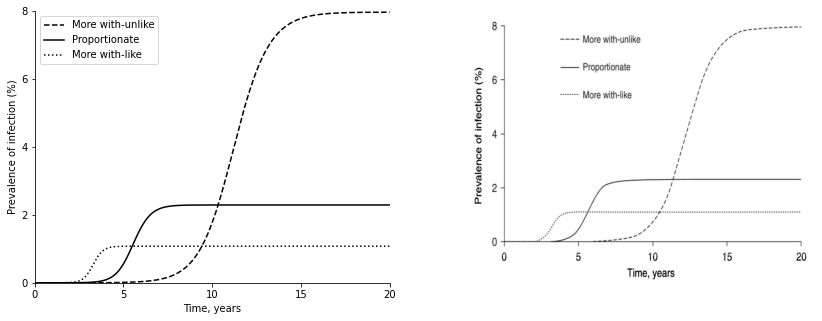

In [7]:
fig, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(14, 5))
line_styles = ("--", "-", ":")

for i_model, name in enumerate(model_names):
    left_ax.plot(
        outputs.index,
        outputs[name],
        color="k",
        linestyle=line_styles[i_model],
        label=name,
    )
left_ax.set_xlim(0., 20.)
left_ax.set_xticks(range(0, 25, 5))
left_ax.set_xlabel("Time, years")
left_ax.set_ylim(0., 8.)
left_ax.set_yticks(range(0, 10, 2))
left_ax.set_ylabel("Prevalence of infection (%)")
left_ax.legend()
left_ax.spines.top.set_visible(False)
left_ax.spines.right.set_visible(False)

image = plt.imread("./figures/fig_8_14.jpg")
right_ax.axis("off")
right_ax.imshow(image, aspect="auto");